In [1]:
import gdown

file_id = '1_5bOckQPXI_pAkboJ8kS43ebHe65VeXo'
output = 'dataset-sampah.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1_5bOckQPXI_pAkboJ8kS43ebHe65VeXo
From (redirected): https://drive.google.com/uc?id=1_5bOckQPXI_pAkboJ8kS43ebHe65VeXo&confirm=t&uuid=aef5c0d9-1edc-4c48-8408-d74bf3c663ee
To: c:\Users\Administrator\Documents\Codding\Deteksi Sampah CNN\dataset-sampah.zip
100%|██████████| 42.8M/42.8M [00:20<00:00, 2.11MB/s]


'dataset-sampah.zip'

In [2]:
# 1. Environment setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# 2. Import libraries
from pathlib import Path
from sklearn.metrics import confusion_matrix
from fastai.vision.all import *
import random, pandas as pd, numpy as np
import os, zipfile, shutil, re, seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 3. Unzip dataset
with zipfile.ZipFile("dataset-sampah.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [5]:
# 4. Cek isi folder
base_dir = Path("dataset-sampah")
print(os.listdir(base_dir))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
# 5. Fungsi pembagi dataset
def split_indices(folder, seed1=42, seed2=99):
    n = len(os.listdir(folder))
    full_set = list(range(1, n+1))
    random.seed(seed1)
    train = random.sample(full_set, int(0.5 * n))
    remain = list(set(full_set) - set(train))
    random.seed(seed2)
    valid = random.sample(remain, int(0.5 * len(remain)))
    test = list(set(remain) - set(valid))
    return train, valid, test

In [7]:
# 6. Get filename
def get_names(waste_type, indices):
    return [f"{waste_type}{i}.jpg" for i in indices]

In [8]:
# 7. Pindahkan file
def move_files(source_files, destination_folder):
    for file in source_files:
        shutil.move(str(file), str(destination_folder))

In [9]:
# 8. Buat struktur folder dan pindahkan data
subsets = ['train', 'valid']
waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for subset in subsets:
    for wt in waste_types:
        Path(f"data/{subset}/{wt}").mkdir(parents=True, exist_ok=True)

Path("data/test").mkdir(parents=True, exist_ok=True)

for wt in waste_types:
    source_folder = base_dir/wt
    train_idx, valid_idx, test_idx = split_indices(source_folder)
    
    for name_list, subset_folder in zip(
        [train_idx, valid_idx, test_idx],
        [f"data/train/{wt}", f"data/valid/{wt}", "data/test"]
    ):
        fnames = get_names(wt, name_list)
        move_files([source_folder/f for f in fnames], Path(subset_folder))

In [10]:
# 9. Path ke data
path = Path("data")

In [11]:
# 10. Load data menggunakan FastAI v2
dls = ImageDataLoaders.from_folder(
    path, 
    train='train', 
    valid='valid',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(flip_vert=True),
    bs=10
)


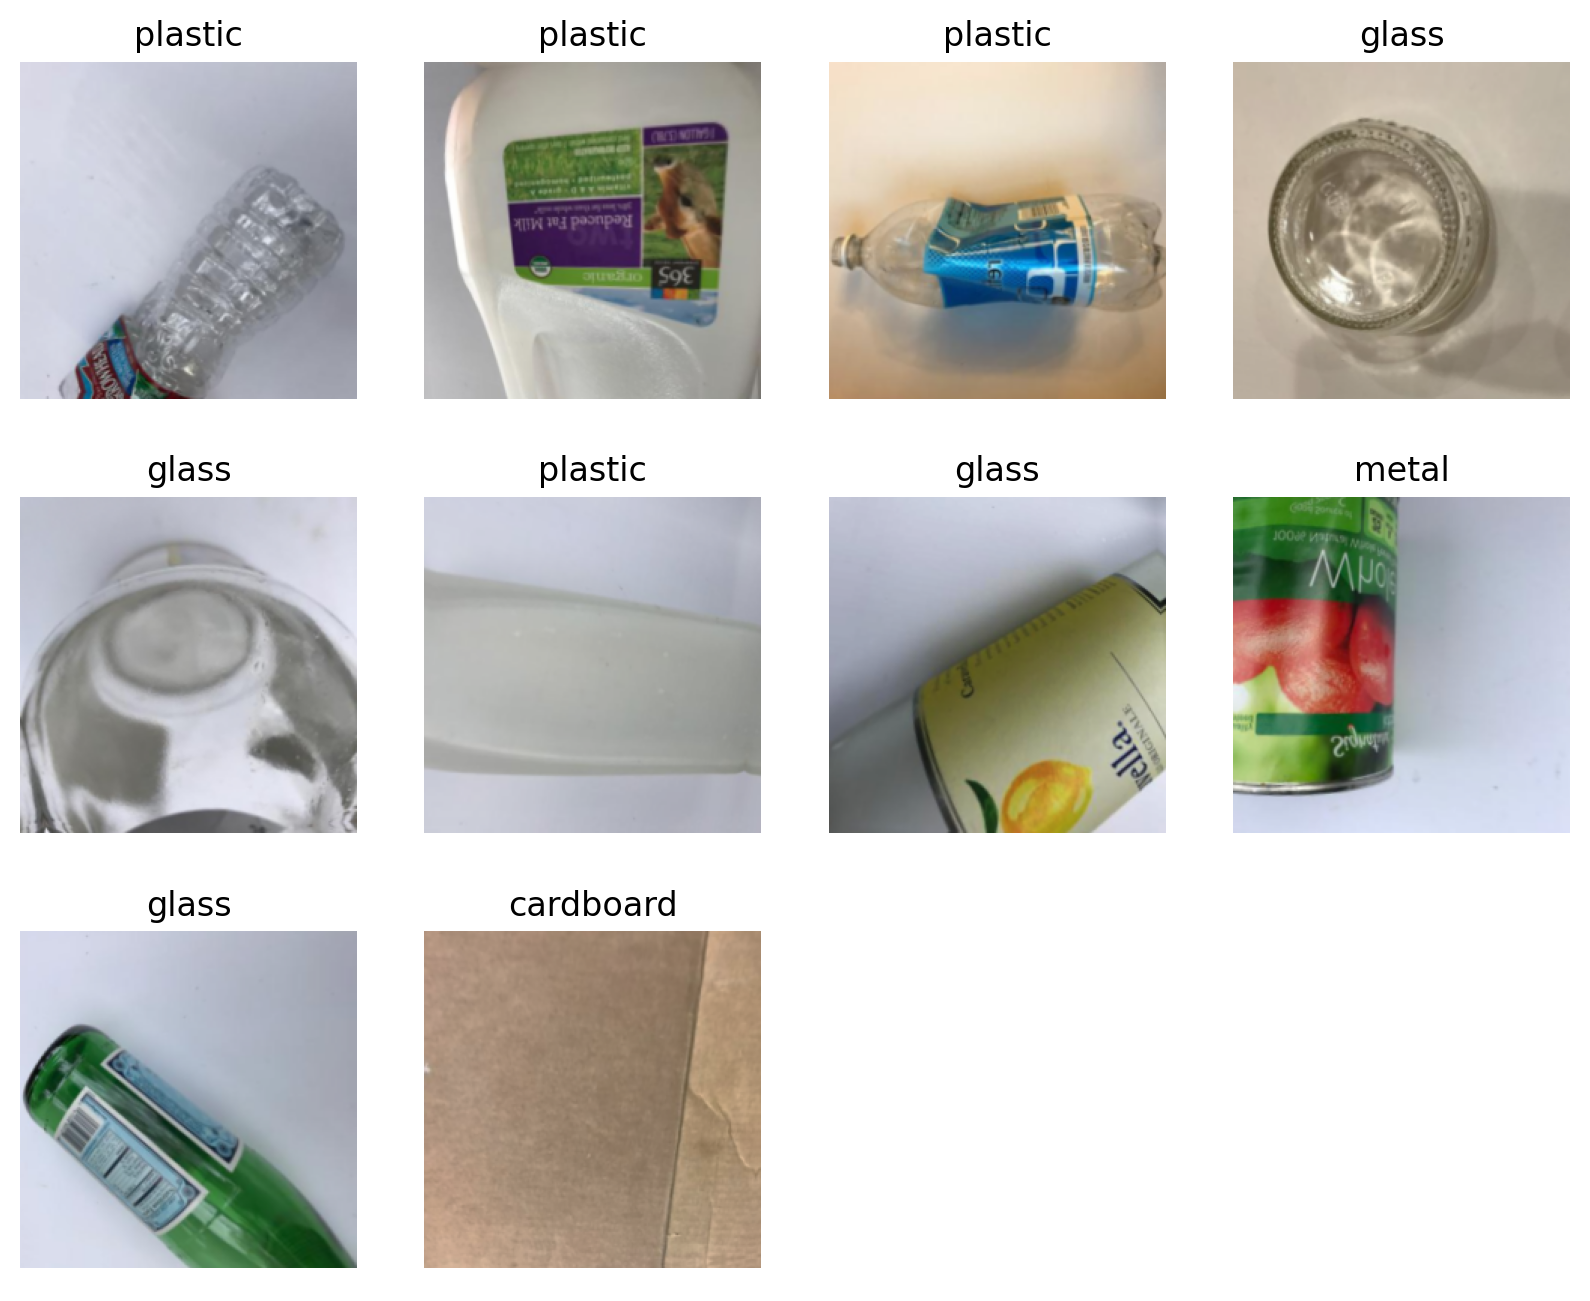

In [12]:
# 11. Cek batch
dls.show_batch(max_n=12, figsize=(10, 8))


In [13]:
# 12. Model dan training
learn = cnn_learner(dls, resnet34, metrics=error_rate)

c:\Python313\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0020892962347716093)

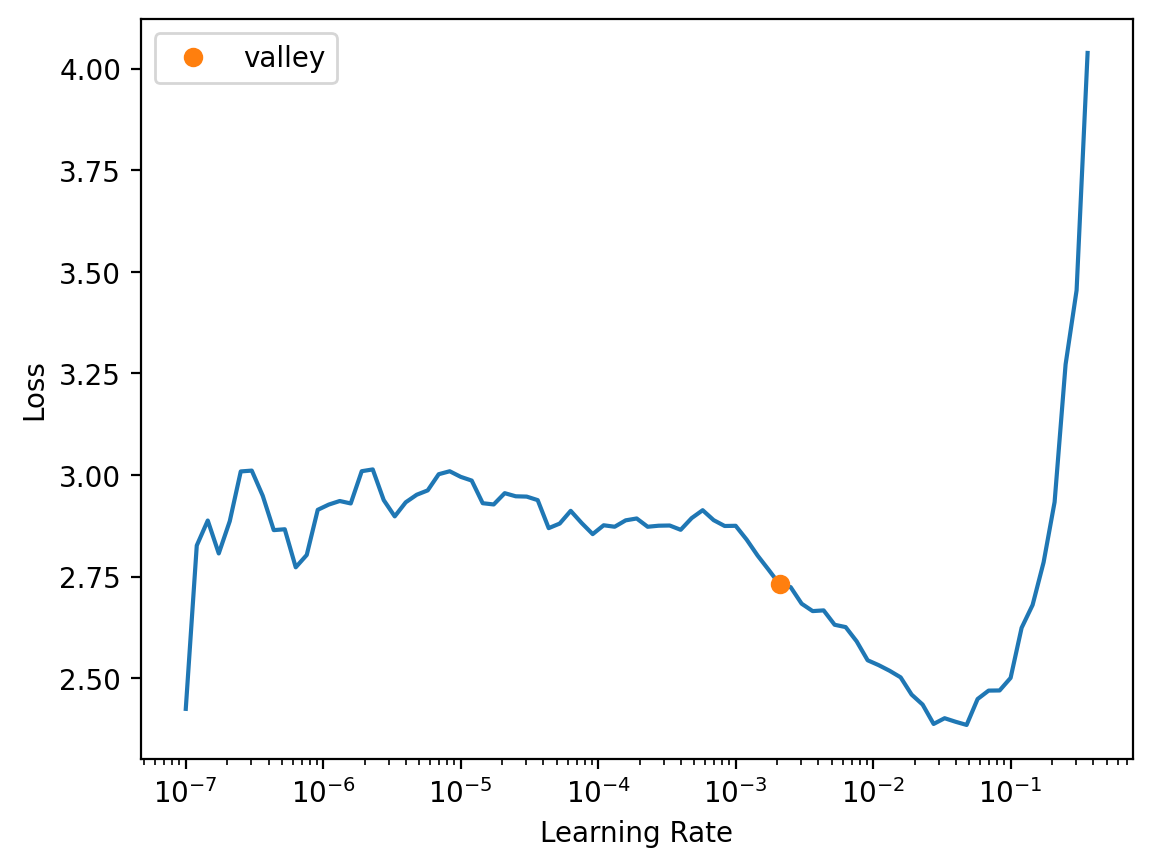

In [14]:
# 13. Learning rate finder
learn.lr_find()

In [ ]:
# 14. Training
learn.fine_tune(2, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.804262,1.267496,0.320635,05:12


epoch,train_loss,valid_loss,error_rate,time
0,1.484487,1.156936,0.336508,07:06
1,1.017062,0.551962,0.207937,06:35


In [16]:
# 14.1 Menyimpan model
learn.export('best_model.pkl')
print("Model berhasil diekspor ke best_model.pkl")


Model berhasil diekspor ke best_model.pkl


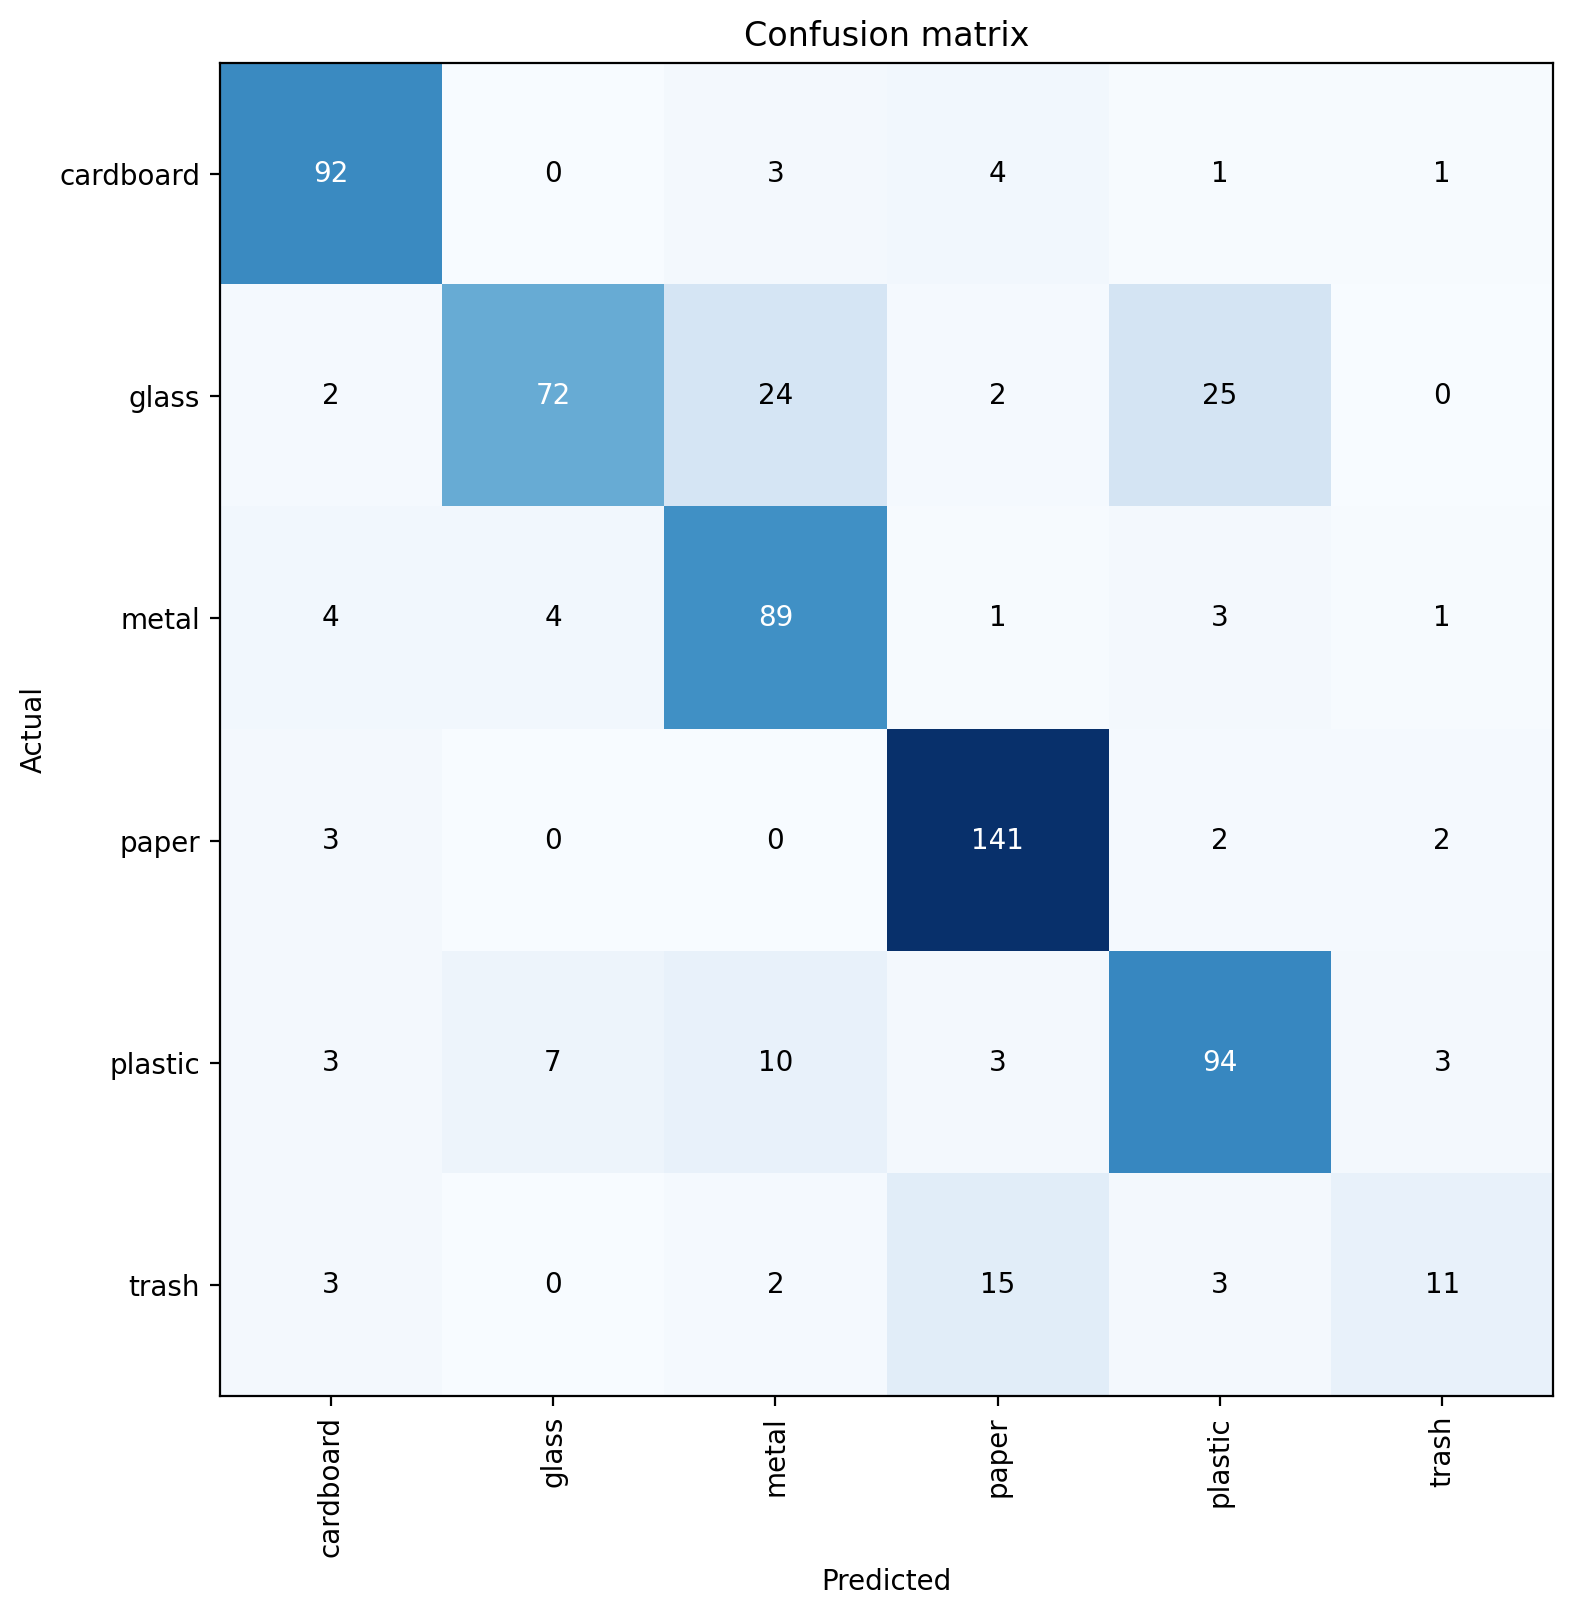

In [17]:
# 15. Evaluasi
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8))

In [18]:
# 16. Prediksi di test set
test_path = path/'test'
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files)
preds, _ = learn.get_preds(dl=test_dl)

In [19]:
# 17. Konversi prediksi ke label
labels = learn.dls.vocab
max_idxs = preds.argmax(dim=1)
yhat = [labels[i] for i in max_idxs]


In [ ]:
# 18. Ekstraksi label ground truth dari nama file
y = [re.search(r'([a-z]+)[0-9]+', f.name).group(1) for f in test_files]


<Axes: >

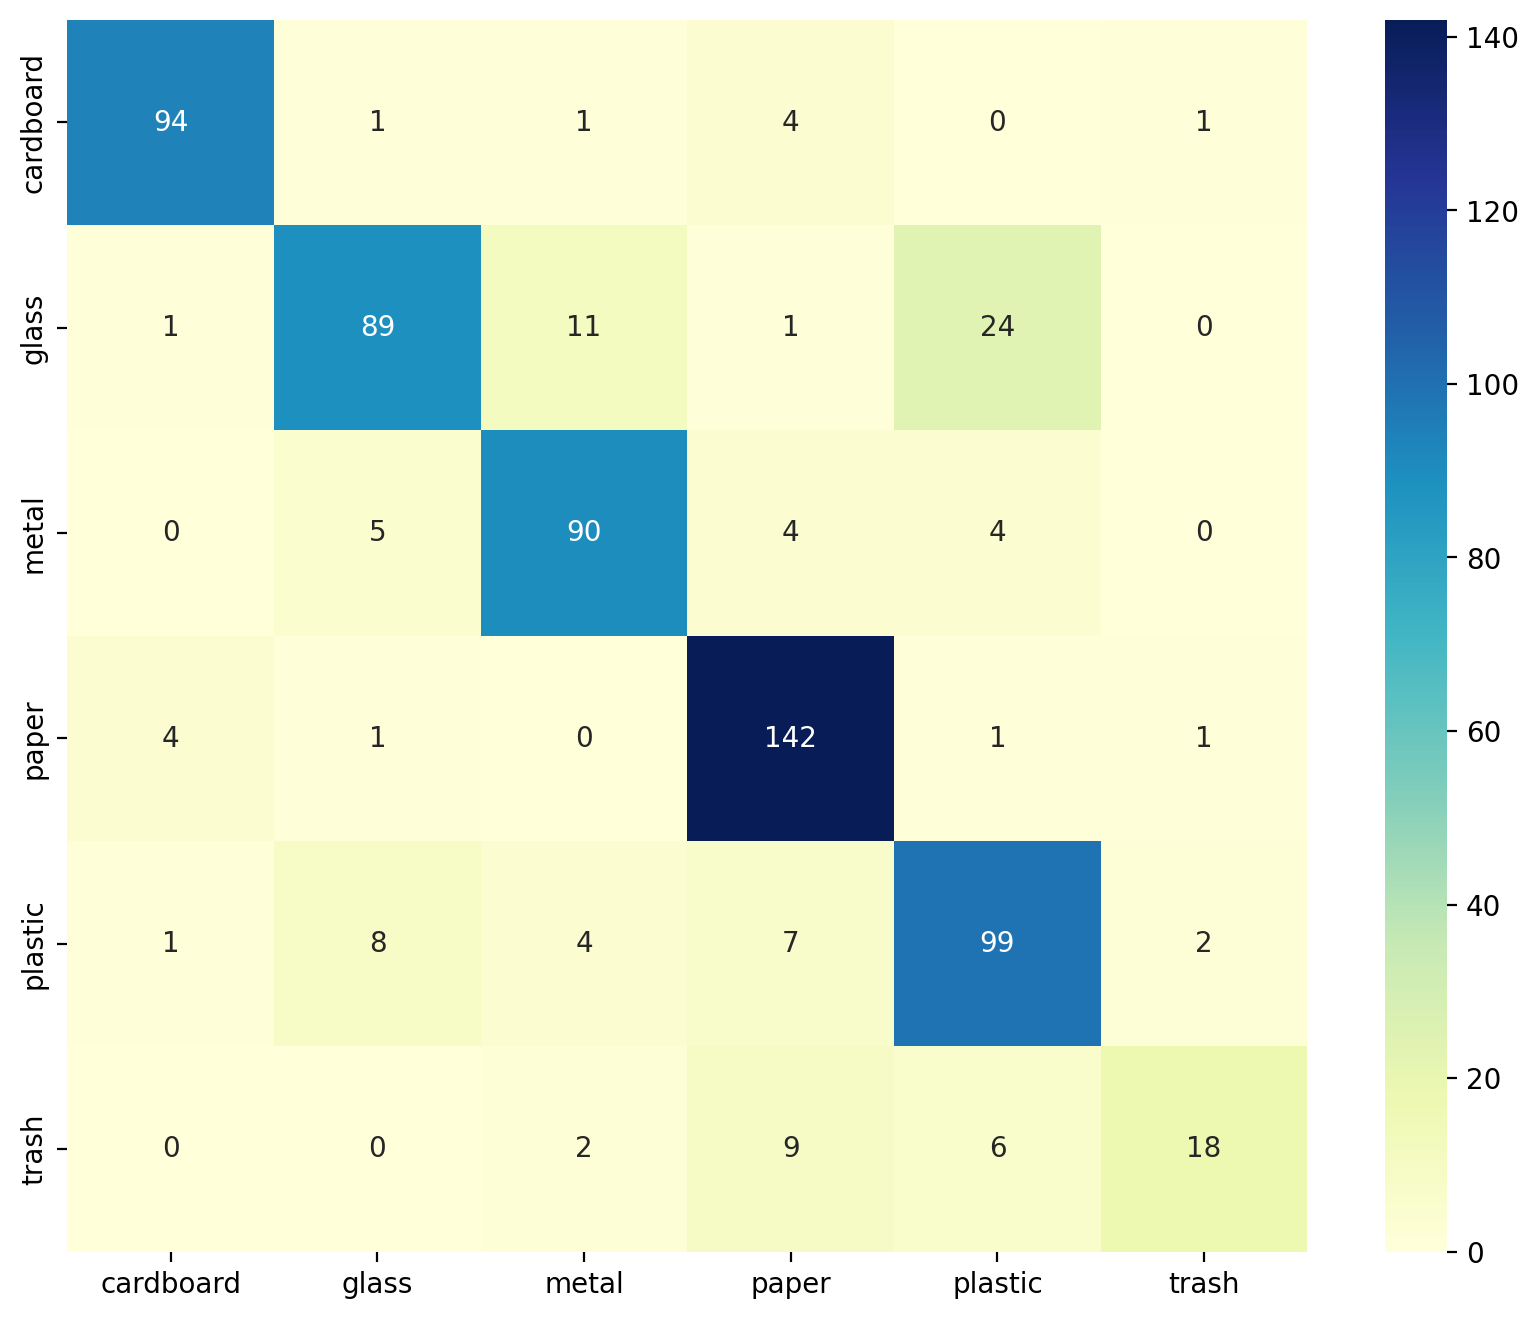

In [ ]:
# 19. Confusion matrix
cm = confusion_matrix(y, yhat, labels=waste_types)
df_cm = pd.DataFrame(cm, index=waste_types, columns=waste_types)
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')

In [22]:
# 20. Akurasi manual
accuracy = np.trace(cm) / np.sum(cm)
print(f"Akurasi: {accuracy:.4f}")

Akurasi: 0.8378


In [ ]:
# 21. Error paling sering
print(interp.most_confused(min_val=2))  

[('glass', 'plastic', np.int64(25)), ('glass', 'metal', np.int64(24)), ('trash', 'paper', np.int64(15)), ('plastic', 'metal', np.int64(10)), ('plastic', 'glass', np.int64(7)), ('cardboard', 'paper', np.int64(4)), ('metal', 'cardboard', np.int64(4)), ('metal', 'glass', np.int64(4)), ('cardboard', 'metal', np.int64(3)), ('metal', 'plastic', np.int64(3)), ('paper', 'cardboard', np.int64(3)), ('plastic', 'cardboard', np.int64(3)), ('plastic', 'paper', np.int64(3)), ('plastic', 'trash', np.int64(3)), ('trash', 'cardboard', np.int64(3)), ('trash', 'plastic', np.int64(3)), ('glass', 'cardboard', np.int64(2)), ('glass', 'paper', np.int64(2)), ('paper', 'plastic', np.int64(2)), ('paper', 'trash', np.int64(2)), ('trash', 'metal', np.int64(2))]


In [ ]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
pip install pyngrok

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
!ngrok config add-authtoken 2ynjAWrNd4G016yV43YZYryBAkJ_3d99XqEundo7YtxzotzrR

Authtoken saved to configuration file: C:\Users\Administrator\AppData\Local/ngrok/ngrok.yml


In [27]:
import os

os.system("ngrok config add-authtoken 2ynjAWrNd4G016yV43YZYryBAkJ_3d99XqEundo7YtxzotzrR")

0

In [30]:
%%writefile app.py
#
import streamlit as st
from PIL import Image
from fastai.vision.all import *
import pathlib
import os

# ✅ Patch untuk Windows
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# Konfigurasi halaman
st.set_page_config(page_title="Deteksi Jenis Sampah", page_icon="🗑")
st.title("🗑 Deteksi Jenis Sampah")
st.write("Upload gambar sampah untuk diklasifikasikan dan dapatkan tips penanganannya.")

# ✅ Tips penanganan per jenis sampah
waste_handling_tips = {
    "cardboard": "📦 Kardus sebaiknya dipipihkan dan dikeringkan. Daur ulang atau digunakan kembali untuk kerajinan.",
    "glass": "🧪 Kaca dapat didaur ulang. Pisahkan berdasarkan warna, dan jangan dicampur dengan sampah organik.",
    "metal": "🔩 Logam seperti kaleng bisa dijual ke pengepul. Bersihkan dulu sebelum dikumpulkan.",
    "paper": "📄 Kertas bekas bisa didaur ulang. Jangan campur dengan sampah basah.",
    "plastic": "♻ Plastik bersih bisa didaur ulang. Hindari membakar karena menghasilkan racun.",
    "trash": "🚮 Sampah residu tidak bisa didaur ulang. Buang ke tempat sampah biasa atau TPA.",
}

# ✅ Cek apakah model tersedia
model_path = "data/best_model.pkl"
if not os.path.exists(model_path):
    st.error(f"❌ Model tidak ditemukan: {model_path}")
    st.stop()

# ✅ Load model
try:
    model = load_learner(model_path)
except Exception as e:
    st.error(f"❌ Gagal memuat model: {e}")
    st.stop()

# ✅ Upload gambar
uploaded_file = st.file_uploader("📷 Pilih gambar...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Gambar yang diunggah", use_container_width=True)

    if st.button("🔍 Deteksi Jenis Sampah"):
        try:
            img_fastai = PILImage.create(image)
            pred, pred_idx, probs = model.predict(img_fastai)

            # ✅ Tampilkan hasil prediksi
            st.subheader(f"Hasil Prediksi: `{pred}`")
            st.write(f"🎯 Probabilitas Tertinggi: {probs[pred_idx]:.4f}")

            # ✅ Detail probabilitas semua kelas
            st.subheader("🔎 Probabilitas Semua Kelas:")
            for label, prob in zip(model.dls.vocab, probs):
                st.write(f"- {label}: {prob:.4f}")

            # ✅ Tips penanganan
            st.subheader("🧾 Tips Penanganan:")
            tip = waste_handling_tips.get(str(pred).lower(), "⚠️ Tidak ada informasi penanganan untuk kategori ini.")
            st.info(tip)

        except Exception as e:
            st.error(f"❌ Terjadi kesalahan saat prediksi: {e}")

# ✅ Kembalikan patch jika perlu
pathlib.PosixPath = temp



Overwriting app.py


In [29]:
from pyngrok import ngrok
import threading
import os

ngrok.kill()

def run_streamlit():
    os.system("streamlit run app.py --server.port 8501")

# Jalankan Streamlit di thread terpisah
thread = threading.Thread(target=run_streamlit)
thread.start()

# Ekspos Streamlit ke internet menggunakan Ngrok
public_url = ngrok.connect(addr="8501")
print(f"Streamlit app is live at: {public_url}")

Streamlit app is live at: NgrokTunnel: "https://3f4f50946234.ngrok-free.app" -> "http://localhost:8501"


t=2025-07-24T22:48:00+0700 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=63b4b11f5f10 err="read tcp 192.168.1.11:51395->3.133.228.214:443: wsarecv: An established connection was aborted by the software in your host machine."
t=2025-07-24T22:48:03+0700 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
t=2025-07-24T22:48:05+0700 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account 